**This note book contains a neutral network model for identifying tutle faces from pictures by drawing a bounding box on the indentified face turtle face in a given Image**

**Working**

1.Added a new column called class to create labels that is to say; Turtle face and Background .

2.Trained a yolov5 model to indentify the turtle face from the image test data set.

3.At first used one epoch and the model was not perfoming well then Used 10 epoches in building the final model. **Note the more the epoches the better the performance of the model**

**Performance Metrics:**
**P (Precision): 0.994 (99.4%) **- Precision measures how accurate the model’s positive predictions are. High precision here indicates that most detected turtle faces were indeed true positives.

**R (Recall): 0.994 (99.4%)** - Recall shows how well the model identifies all relevant objects. A recall close to 1 means the model detects nearly every instance.

**mAP50 (Mean Average Precision at 50% IoU)**: 0.995 (99.5%) - mAP50 is a primary metric for object detection, evaluating how accurately the bounding boxes match ground-truth boxes at 50% Intersection over Union (IoU). High mAP50 indicates precise bounding boxes.

**mAP50-95: 0.872 (87.2%)** - This averages the mAP over IoU thresholds from 50% to 95%. It’s a more stringent measure of accuracy. The model’s 87.2% here suggests high-quality detections at various IoU thresholds.

Below is the out put of the model with bounding box drawn on the identified turtle face in the image


In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import shutil
import random
from pathlib import Path
import yaml
from IPython.display import Image, display
import glob

# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone the repository
%cd yolov5
!pip install -r requirements.txt  # install dependencies

# Move back to the main directory
%cd ..

# Prepare dataset directories
#!unzip -qq '/content/IMAGES_1024.zip'
#!unzip -qq '/content/IMAGES_512.zip'


# Prepare dataset directories
!cp '/content/IMAGES_1024.zip' .
!unzip -q IMAGES_1024.zip
image_folder_1024 = 'IMAGES_1024'
!cp '/content/IMAGES_512.zip' .
!unzip -q IMAGES_512.zip
image_folder_512 = 'IMAGES_512'

# Load train and sample submission CSV files
train = pd.read_csv('/content/Train.csv')
ss = pd.read_csv('/content/SampleSubmission.csv')

# Prepare image lists
imgs_1024 = [i[:-4] for i in os.listdir('/content/IMAGES_1024')]
imgs_512 = [i[:-4] for i in os.listdir('/content/IMAGES_512')]
vals = [i in imgs_512 for i in imgs_1024]
print(all(vals))
print(len(imgs_512), len(imgs_1024))

# Image dimensions for YOLO format
im = cv2.imread('/content/IMAGES_512/00309D7D.JPG')
img_h, img_w, _ = im.shape

# Data transformation to YOLO format
train['id'] = 0
train['class'] = 'turtle_face'

def coco_to_yolo(x1, y1, w, h, image_w, image_h):
    return [(2 * x1 + w) / 2, (2 * y1 + h) / 2, w, h]

train['yolo'] = train.apply(lambda row: coco_to_yolo(row['x'], row['y'], row['w'], row['h'], img_w, img_h), axis=1)

# Create directories for YOLO dataset structure
!mkdir -p Turtle_dataset/train/images Turtle_dataset/train/labels
!mkdir -p Turtle_dataset/val/images Turtle_dataset/val/labels
!mkdir -p Turtle_dataset/test/images Turtle_dataset/test/labels

# Split the dataset
train_files = random.sample(train['Image_ID'].values.tolist(), 1193)
val_files = random.sample([i for i in train['Image_ID'].values.tolist() if i not in train_files], 120)
test_files = [i for i in train['Image_ID'].values.tolist() if i not in train_files and i not in val_files]

for f in train_files:
    shutil.copyfile(f'/content/IMAGES_512/{f}.JPG', f'/content/Turtle_dataset/train/images/{f}.JPG')
for f in val_files:
    shutil.copyfile(f'/content/IMAGES_512/{f}.JPG', f'/content/Turtle_dataset/val/images/{f}.JPG')
for f in test_files:
    shutil.copyfile(f'/content/IMAGES_512/{f}.JPG', f'/content/Turtle_dataset/test/images/{f}.JPG')

# Create YOLO format labels
def create_yolo_labels(image_path, df, labels_path):
    for i in os.listdir(image_path):
        annotations = df[df['Image_ID'] == i[:-4]]
        filename = f'{labels_path}/{i[:-4]}.txt'
        with open(filename, 'w') as f:
            for _, row in annotations.iterrows():
                xc, yc, x, y = row['yolo'][0], row['yolo'][1], row['yolo'][2], row['yolo'][3]
                class_id = 0
                f.write(f"{class_id} {xc} {yc} {x} {y}\n")

for k in ['train', 'val', 'test']:
    create_yolo_labels(f'/content/Turtle_dataset/{k}/images', train, f'/content/Turtle_dataset/{k}/labels')

# YAML configuration file for YOLOv5
labels = ['turtle_face']
yaml_dict = {
    'path': '/content/Turtle_dataset',
    'train': 'train/images',
    'val': 'val/images',
    'names': labels,
    'nc': 1
}

with open('/content/Turtle_dataset/data.yaml', 'w+') as yml_file:
    yaml.dump(yaml_dict, yml_file)

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
/content
cp: '/content/IMAGES_1024.zip' and './IMAGES_1024.zip' are the same file
warning [IMAGES_1024.zip]:  32505856 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  32505856
  (attempting to re-compensate)
error: invalid zip file with overlapped components (possible zip bomb)
cp: '/content/IMAGES_512.zip' and './IMAGES_512.zip' are the same file
replace IMAGES_512/974873B6.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
True
2023 0


**Training the Model with one Epoch**

In [4]:
# Train the YOLOv5 model
!python yolov5/train.py --img 640 --batch 16 --epochs 1 --data /content/Turtle_dataset/data.yaml --weights yolov5s.pt --device cpu

# Display training results
Image(filename=f"/content/yolov5/runs/train/exp/results.png", width=1000)
Image(filename=f"/content/yolov5/runs/train/exp/train_batch0.jpg", width=1000)
Image(filename=f"/content/yolov5/runs/train/exp/confusion_matrix.png", width=1000)

# Validate the model on the test set
!python yolov5/val.py --data /content/Turtle_dataset/data.yaml --weights /content/yolov5/runs/train/exp/weights/best.pt

# Display some validation results
for image_path in glob.glob(f'/content/yolov5/runs/val/exp/*.jpg')[:3]:
    display(Image(filename=image_path, width=600))

Output hidden; open in https://colab.research.google.com to view.

**Training The Model using 10 epoches and Displaying Validation Results**

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
/content
replace IMAGES_1024/974873B6.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace IMAGES_512/974873B6.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
True
2023 2021
2024-11-05 13:09:48.929245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 13:09:49.116313: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 13:09:49.171630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/Turtle_dataset/data.yaml, hyp=yolov5/data/hyps/hyp.s

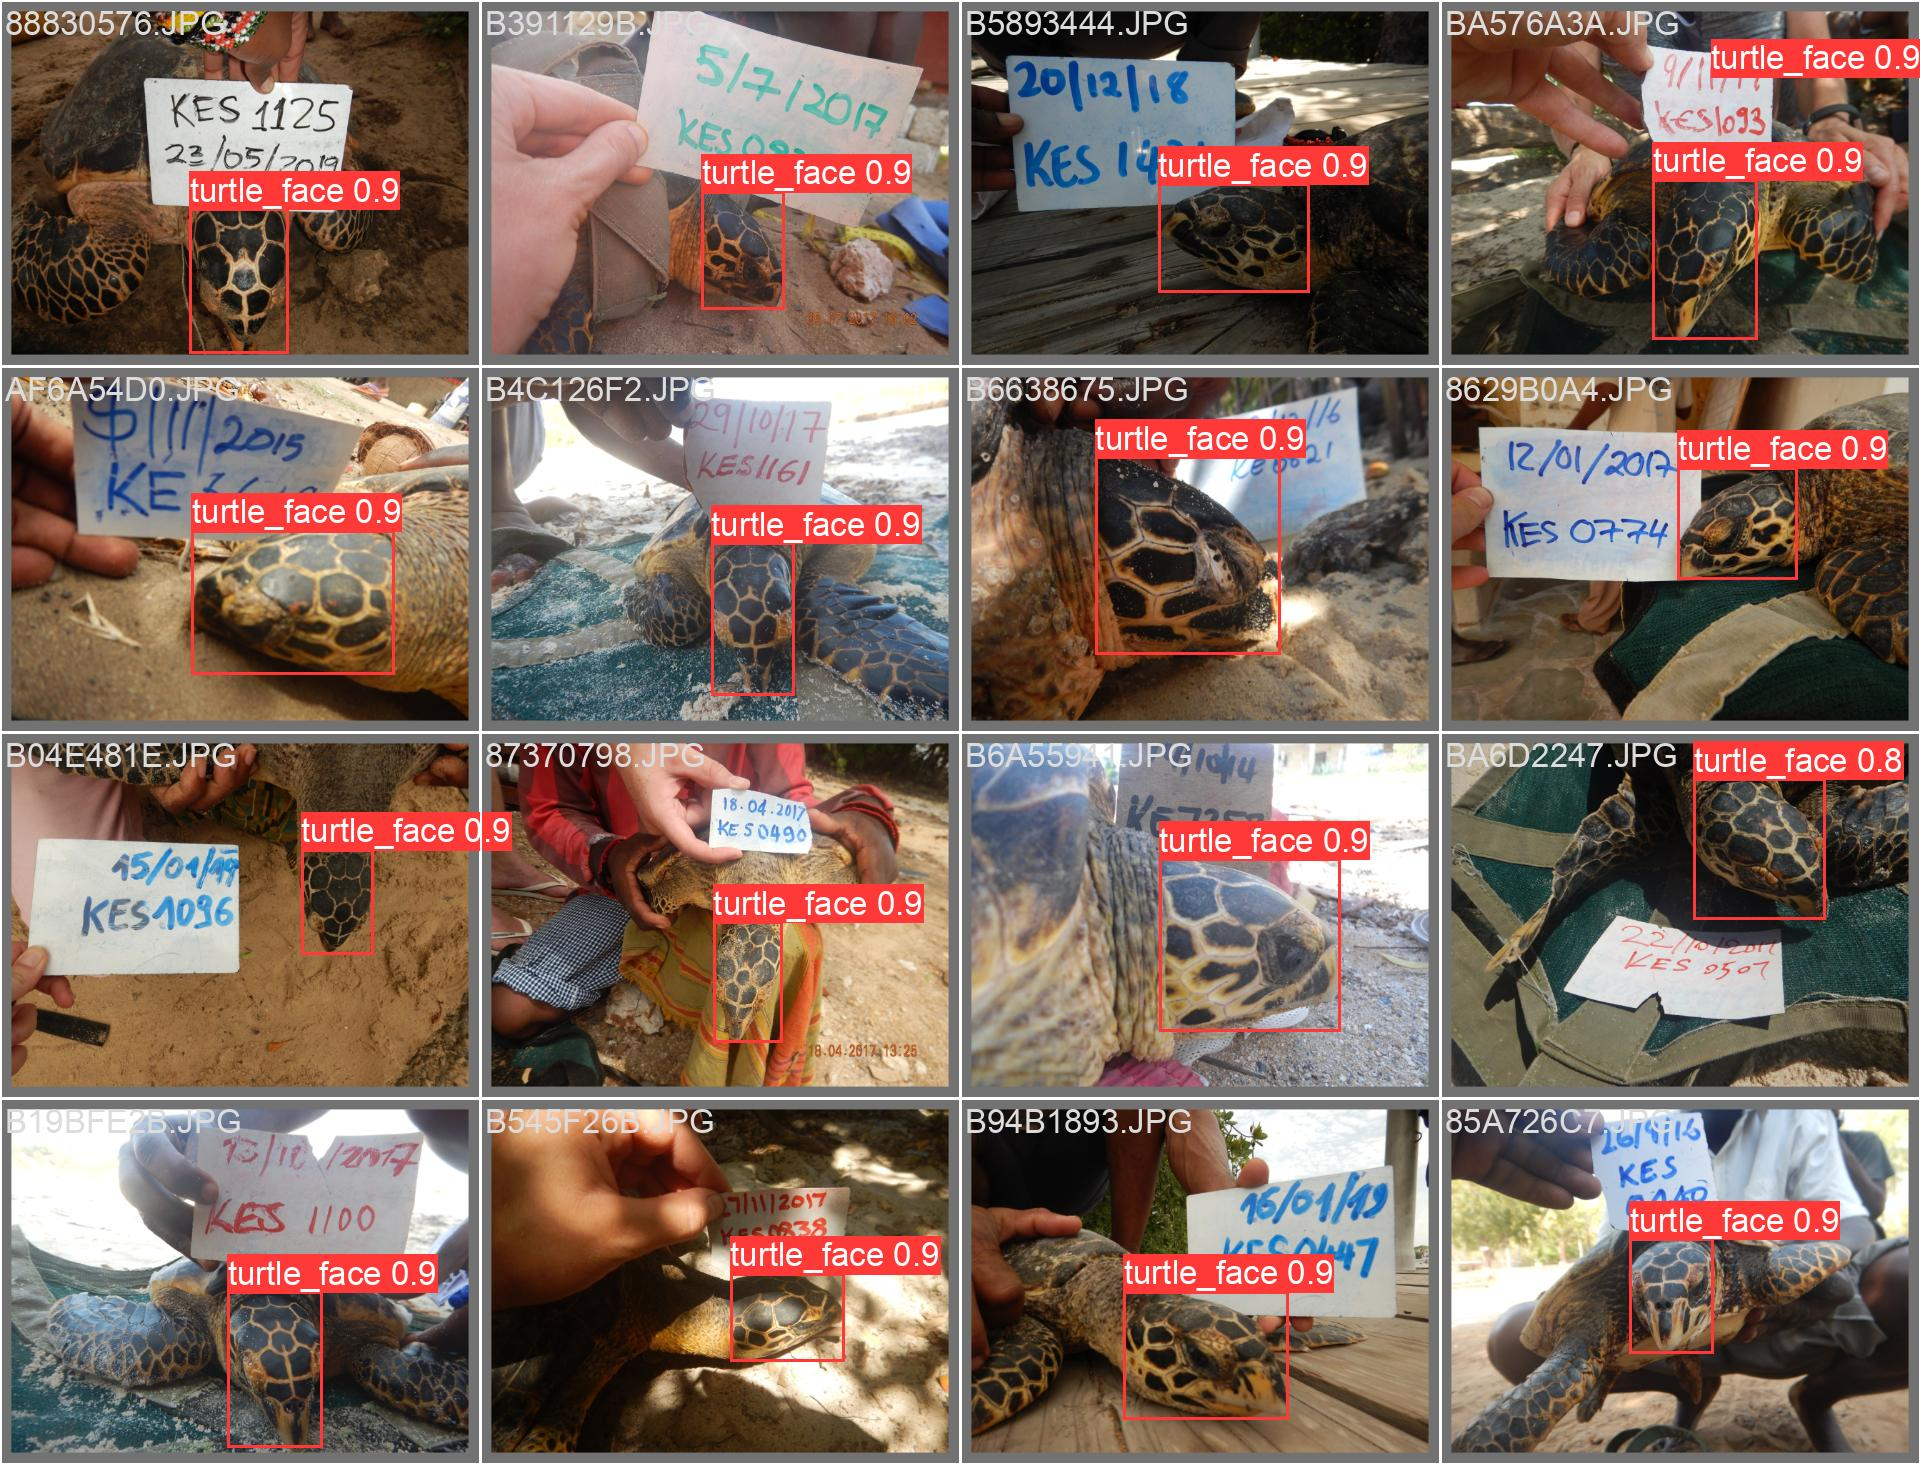

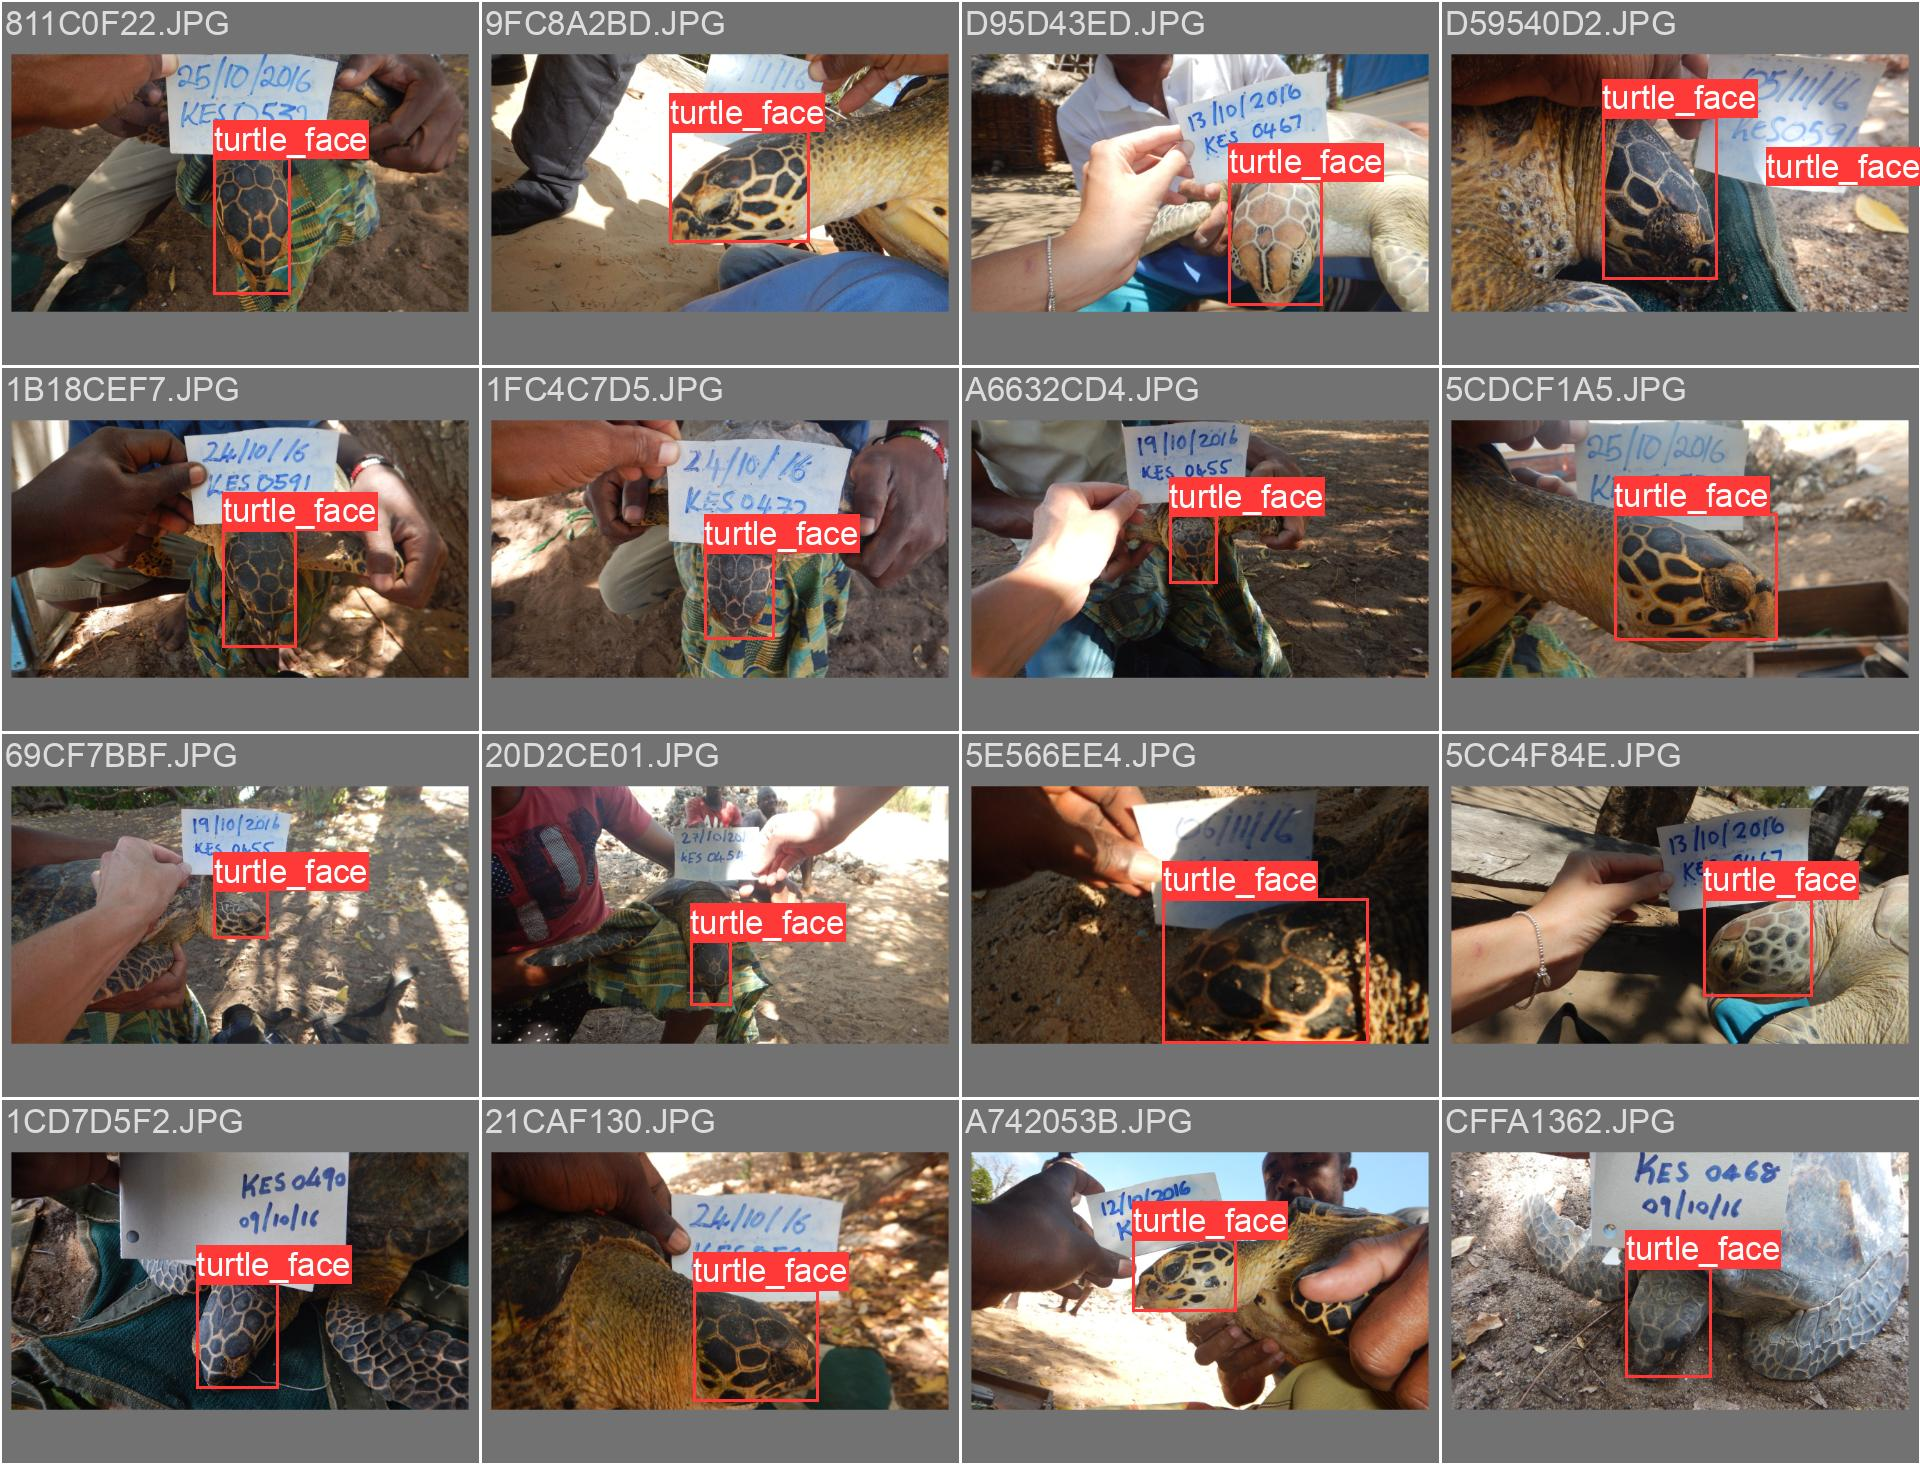

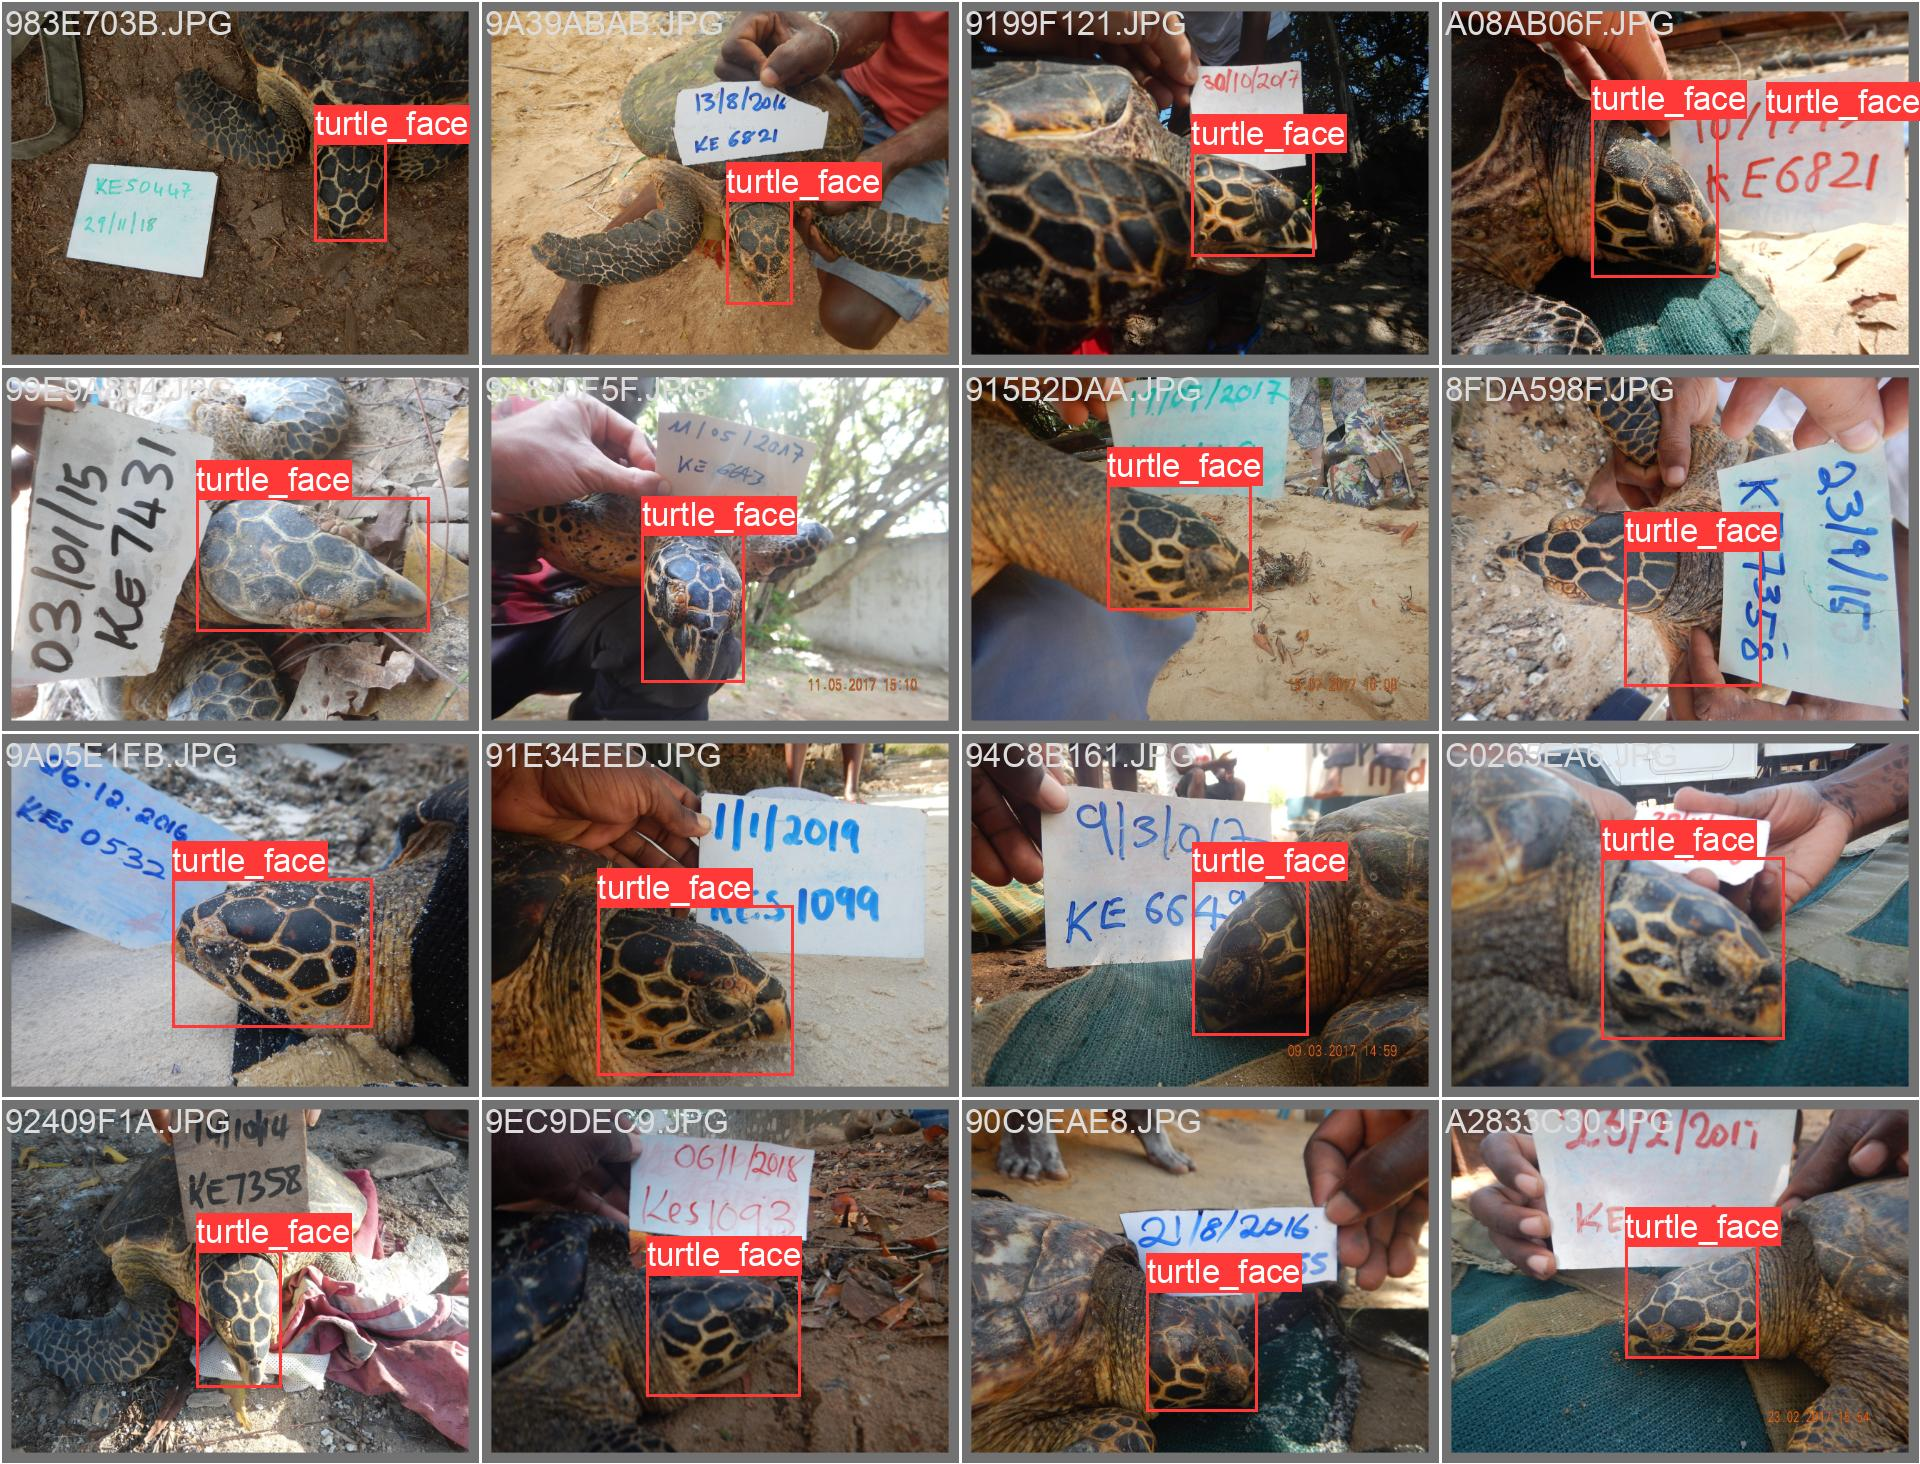

In [ ]:


# Train the YOLOv5 model
!python yolov5/train.py --img 640 --batch 16 --epochs 10 --data /content/Turtle_dataset/data.yaml --weights yolov5s.pt --device cpu

# Display training results
Image(filename=f"/content/yolov5/runs/train/exp/results.png", width=1000)
Image(filename=f"/content/yolov5/runs/train/exp/train_batch0.jpg", width=1000)
Image(filename=f"/content/yolov5/runs/train/exp/confusion_matrix.png", width=1000)

# Validate the model on the test set
!python yolov5/val.py --data /content/Turtle_dataset/data.yaml --weights /content/yolov5/runs/train/exp/weights/best.pt

# Display some validation results
for image_path in glob.glob(f'/content/yolov5/runs/val/exp/*.jpg')[:3]:
    display(Image(filename=image_path, width=600))
    print("\n")
